# Using Landlab to Model Tectonic Activities in a Landscape Evolution Model 
This notebook is created as a part of the 2020 ESPIn summer school

**Authors**: Liang Xue, Chris Sheehan, Xiaoni Hu, Eyal Marder & Gustav Pallisgaard-Olesen
**Version**: This version of the notebook is a continuation of the ESPIn 2020 project with complete documentation and comments made b 

This notebook contains examples of how to use Landlab components to simulate the evolution of detachment-limited channels under different cases of active uplift and how a changing surface load affects the elastic lithosphere.
We will also show some of the terrain analysis tools available in Landlab such as Chi-index analysis and slope steepness-indeces. 

The goal is to show how easily one can set up and run a simple LEM with different tectonic settings using Landlab, and quickly get to a point when you can do some real science! 

**Outline**
1. A basic Landscape Evolution Model
2. Investigating lithospheric flexure 
3. Adding faulting to an LEM
4. Terrain analysis with Landlab

All four sections in this notebook will: 
- Run the model on the same 200 by 200 rectangular grid
- Have north, east and west boundaries closed and the south boundary open
- Use the StreamPowerEroder, LinearDiffuser and FlowAccumulator as a basis for the LEM

## 1. A Basic Landscape Evolution Model
This first section describes the nescesarry steps to model the evolution of a landscape undergoing constant tectonic uplift using Landlab.    

First the nescessary python libraries and the Landlab components for the landscape evolution model are imported: 

In [1]:
import numpy as np
from landlab import RasterModelGrid, HexModelGrid
from landlab.components import StreamPowerEroder, LinearDiffuser, FlowAccumulator
from landlab import imshow_grid
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

The size of the grid is defined:

In [2]:
number_of_rows = 200            
number_of_columns = 200        
dxy = 100                        

Landlab's RasterModelGrid is called and because a perfectly flat grid will cause problems with flow routing, random noise is created across the synthetic landscape:

In [3]:
mg = RasterModelGrid((number_of_rows, number_of_columns), dxy)

# Create random noise
np.random.seed(0)                                       # seed set to zero so our figures are reproducible
mg_noise = np.random.rand(mg.number_of_nodes)/1000.     # intial noise on elevation grid

# set up the elevation on the grid
zr = mg.add_zeros('node', 'topographic__elevation')
zr += mg_noise

The boundary conditions are set - here 1 means "open" and 4 means "closed":

In [4]:
East = 4
North = 4
West = 4
South = 1

In [5]:
mg.set_status_at_node_on_edges(right=East, top=North, left=West, bottom=South)

This part allows for different types of uplift. A uniform uplift is used in this instance, but a one-time uplift event, a simple fault or an uplift gradient across the landscape is easily implemented as well:

In [6]:
U = 1E-3

In [7]:
uplift_rate = np.ones(mg.number_of_nodes)*U

## One-time uplift event
#fault_location = 10000  # [m] (original value = 4000)
#uplift_amount = 100 # [m] (original value = 10)
#zr[np.where(mg.node_y>fault_location)] += uplift_amount 

## Continuously-slipping fault, 
#fault_location = 10000  # [m] (Original value = 4000)
#low_uplift_rate = 1E-3 # [m/yr] (Original value = 0.0001)
#high_uplift_rate = 1E-2 # [m/yr] (Original value = 0.0004)
#uplift_rate[np.where(mg.node_y<fault_location)] = low_uplift_rate
#uplift_rate[np.where(mg.node_y>fault_location)] = high_uplift_rate

## Uplift Gradient
#low_uplift_rate = 0.0001 # [m/yr]
#high_uplift_rate = 0.004 # [m/yr]
#uplift_rate_gradient = (high_uplift_rate - low_uplift_rate)/(number_of_rows-3)
#uplift_rate = low_uplift_rate + ((mg.node_y / dxy)-1) * uplift_rate_gradient


The timestep "dt" is set to 1 kyr and the total simulation time "tmax" is set to 300 kyr: 

In [8]:
dt = 1000            # time step [yr]
tmax = 3E5        # time for the model loop to run [yr]

The elapsed time and the time array is initialized for the time loop: 

In [9]:
total_time = 0 
t = np.arange(0, tmax, dt)
qs = np.zeros(len(t))
max_z = np.zeros(len(t))
num = 0

Constants for the stream power equation and hillslope diffusion are defined:

In [10]:
min_drainage_area = 1000
K_hs = 1E-3
K_sp = 1E-4
m_sp = 0.5                  # exponent on drainage area in stream power equation 
n_sp = 1                    # exponent on slope in stream power equation

The Landlab components FlowAccumulator, StreamPowerEroder and LinearDiffuser are initialized: 

In [11]:
frr = FlowAccumulator(mg) 
spr = StreamPowerEroder(mg, K_sp=K_sp, m_sp=m_sp, n_sp=n_sp, threshold_sp=0.0)
dfn = LinearDiffuser(mg, linear_diffusivity=K_hs, deposit = False)

Now the LEM can be advanced through time. The uniform uplift is applied to the elevation of the grid:

In [12]:
for ti in t:
    zr[mg.core_nodes] += uplift_rate[mg.core_nodes]*dt  # uplift the landscape
    Topo1 = np.copy(zr)
    dfn.run_one_step(dt)                                # diffuse the landscape
    frr.run_one_step()                                  # route flow
    spr.run_one_step(dt)                                # fluvial incision
    Topo2 = np.copy(zr)
    qs[num] = np.sum(Topo1-Topo2)*dxy*dxy/dt
    max_z[num] = zr.max()
    num += 1
    total_time += dt                                    # update time keeper
    #print(total_time)

Visualizing the topography of the finished model can be done with imshow_grid:

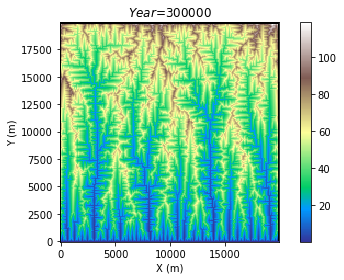

In [13]:
imshow_grid(mg, 'topographic__elevation', grid_units=('m', 'm'), cmap='terrain', allow_colorbar=True)
title_text = '$Year$='+str(total_time)  
plt.title(title_text)
plt.tight_layout()
plt.show()

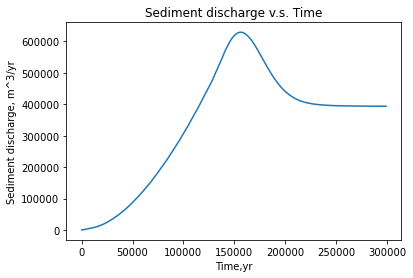

In [14]:
plt.plot(t,qs)
plt.title('Sediment discharge v.s. Time')
plt.xlabel('Time,yr')
plt.ylabel('Sediment discharge, m^3/yr')
plt.show()

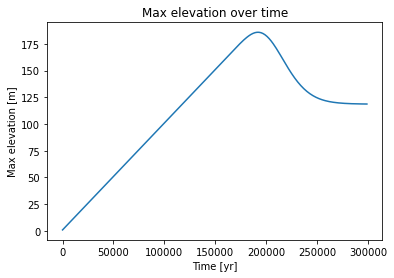

In [15]:
plt.plot(t,max_z)
plt.title('Max elevation over time')
plt.xlabel('Time [yr]')
plt.ylabel('Max elevation [m]')
plt.show()

## 2. Investigating lithospheric flexure




In [16]:
from landlab.components.flexure import Flexure


In [17]:
lith_press = mg.add_zeros("lithosphere__overlying_pressure_increment", at="node")
flex = Flexure(mg)

loads = mg.add_zeros('node', 'load')
dz_flex = mg.add_zeros('node', 'deflection')

In [18]:
Edge = 1000
K_sp1 = 1E-4
K_sp2 = 5E-4

#Define Spatial Erodibility
K_flag = True
if K_flag:
    K_sp = K_sp1
else:
    K_sp = np.ones(mg.number_of_nodes)
    K_sp[np.where(mg.node_y<=Edge)] = K_sp1
    K_sp[np.where(mg.node_y>=Edge)] = K_sp2
    
print(K_sp)

0.0001


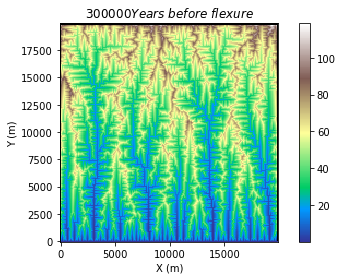

118.686150594


In [19]:
imshow_grid(mg, 'topographic__elevation', grid_units=('m', 'm'), cmap='terrain', allow_colorbar=True)
title_text = str(total_time)+'$Years$ $before$ $flexure$'
plt.title(title_text)
plt.tight_layout()
plt.show()

print(zr.max())

13.0867782995


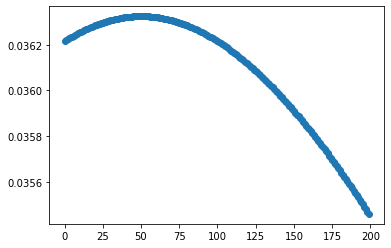

6.93259E+09
0.0368506730146


In [20]:
# Calculate flexure load
rho_s = 2700  # rock density (kg/m^3)
g = 9.81  # gravity constant (m/s^2)
L = 20000 # half plate length (m)
# h = 1000  # sediment fill thickness (m)
h = zr[mg.node_y<Edge].mean()  # sediment fill thickness (m)
print(h)

load = rho_s*9.81*h*L  # effective load (N)
loads[10000] = load

# Calculate deflection
dz_flex = flex.subside_loads(loads, out=None)
dz_flex = dz_flex.flatten()

# update topography
zr -= dz_flex

# Plot deflection transect along middle Y axis
tt = np.where(mg.node_x==10000)
plt.plot(dz_flex[tt], 'o')

plt.show()

print('{:.5E}'.format(load))
print(dz_flex.max())

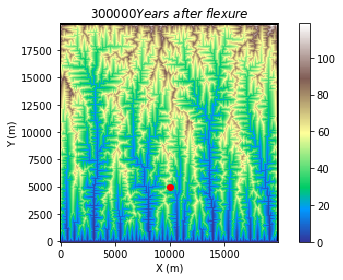

118.651578566


In [21]:
imshow_grid(mg, 'topographic__elevation', grid_units=('m', 'm'), cmap='terrain', allow_colorbar=True)
title_text = str(total_time)+'$Years$ $after$ $flexure$'
plt.scatter(x = [10000], y= [5000], c = 'red')
plt.title(title_text)
plt.tight_layout()
plt.show()

print(zr.max())

##  3. Adding faulting to an LEM



In [22]:
from landlab.components import NormalFault, ChannelProfiler, ChiFinder, SteepnessFinder

In [23]:
theta = m_sp / n_sp


#setting up lithology
Ksp = np.ones(mg.number_of_nodes)
Ksp [np.where(mg.node_y>10000)] = 1e-4
Ksp [np.where(mg.node_y<= 10000)] = 0.7e-3



frr = FlowAccumulator(mg) 
#spr = StreamPowerEroder(mg, K_sp=K_sp, m_sp=m_sp, n_sp=n_sp, threshold_sp=0.0)
spr = StreamPowerEroder(mg, K_sp=Ksp, m_sp=m_sp, n_sp=n_sp, threshold_sp=0.0)
dfn = LinearDiffuser(mg, linear_diffusivity=K_hs, deposit = False)

# initialize the component that will calculate channel steepness
sf = SteepnessFinder(mg,reference_concavity=theta, min_drainage_area=1000.0)
# initialize the component that will calculate the chi index
cf = ChiFinder(mg, min_drainage_area=1000.0,
               reference_concavity= theta,
               use_true_dx=True)

In [24]:
tmax = 1e5+1
total_time = 0 
t = np.arange(0, tmax, dt)

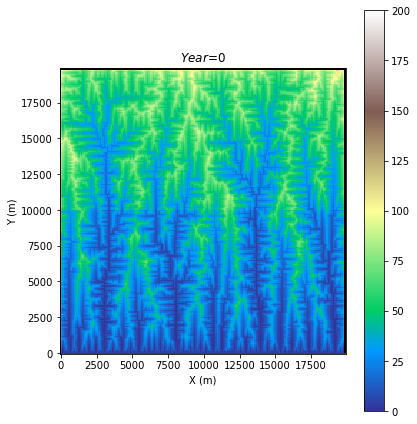

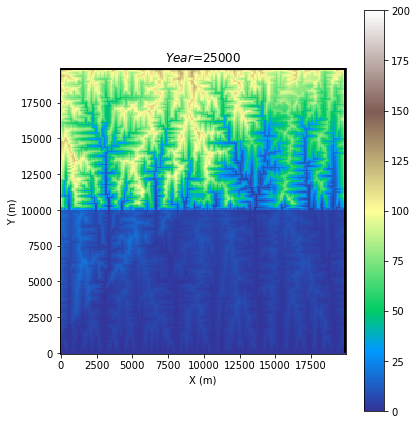

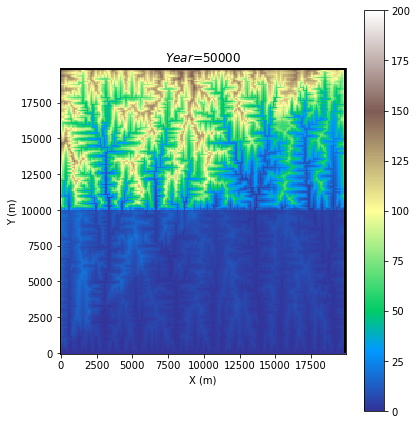

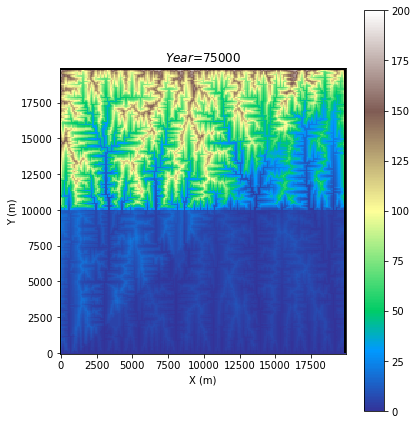

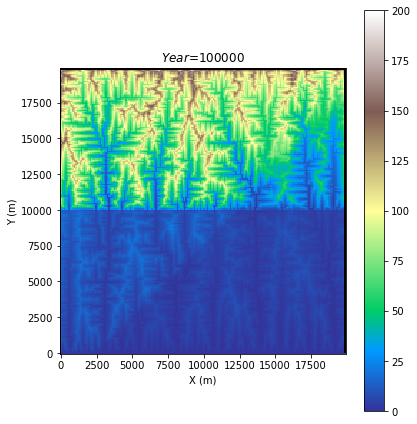

In [25]:
for ti in t:
    zr[mg.core_nodes] += uplift_rate[mg.core_nodes]*dt  # uplift the landscape
    dfn.run_one_step(dt)                                # diffuse the landscape
    frr.run_one_step()                                  # route flow
    spr.run_one_step(dt)                                # fluvial incision

    
# fault  location solver
# set up rate of fault propagation
# def a vector df(x, y) as the fault dipping and propagation with constant rate
    dfx = 0
    dfy = -0.5e-1

    # the rate can be time-dependant with dt
    xmax = dxy*mg.shape[0]
    ymax = dxy*mg.shape[1]

    # fault function 
    #ff = x - y + 2500
    # x -y = -2500
    # function 1:  a*x + b*y  = c
    # function 2: x =0
    # function 3: y = ymax 
    # a = np.array ([1,-1])
    c = np.array([0,0])
    # np.linalg.solve ()
    #function 12
    x1, y1 = np.linalg.solve (np.array ([[1,-1], [1, 0]]), np.array ([-2500, 0]))

    #function 13
    x2, y2 = np.linalg.solve (np.array ([[1,-1], [0, 1]]), np.array ([-2500, ymax]))
#    print ('The end points of the fault is {},{} and {},{}.'.format(x1,y1, x2,y2))

#set the fault parameter
# vertical fault
#     param_dict = {'faulted_surface': 'topographic__elevation',
#                  'fault_dip_angle': 90.0,
#                  'fault_throw_rate_through_time': {'time': [0, tmax],
#                                                    'rate': [1e-4, 1e-4]},
#                  'fault_trace': {'y1':0, 
#                                 'x1': 10000+ dfy*total_time,
#                                 'y2': 7500, 
#                                 'x2': 10000+ dfy*total_time}, 
#                 'include_boundaries': False}
    
# static    
    param_dict = {'faulted_surface': 'topographic__elevation',
                 'fault_dip_angle': 90.0,
                 'fault_throw_rate_through_time': {'time': [0, tmax],
                                                   'rate': [1e-3, 1e-3]},
                 'fault_trace': {'y1': y1 + dfy*total_time, 
                                'x1': x1 + dfx*total_time,
                                'y2': y2 + dfy*total_time, 
                                'x2': x2 + dfx*total_time}, 
                'include_boundaries': False}
#
# horizontal fault 
#     param_dict = {'faulted_surface': 'topographic__elevation',
#                  'fault_dip_angle': 90.0,
#                  'fault_throw_rate_through_time': {'time': [0,  tmax],
#                                                    'rate': [1e-3,  1e-3]},
#                  'fault_trace': {'y1':7500+ dfy*total_time, 
#                                 'x1': 0,
#                                 'y2': 7500+ dfy*total_time, 
#                                 'x2': 20000}, 
#                  'include_boundaries': False}

    ft = NormalFault(mg, **param_dict)
    ft.faulted_nodes.reshape(mg.shape)
    ft.run_one_step(dt)                               
    
# plot figure
    if ti %25000 == 0:
        plt.figure(figsize = (6,6))
        imshow_grid(mg, 'topographic__elevation', grid_units=('m', 'm'), vmin= 0, vmax = 200,
                    cmap='terrain', allow_colorbar=True)
        title_text = '$Year$='+str(total_time)  
        plt.title(title_text)
        plt.tight_layout()
    
    total_time += dt                                    # update time keeper
    #print(total_time)

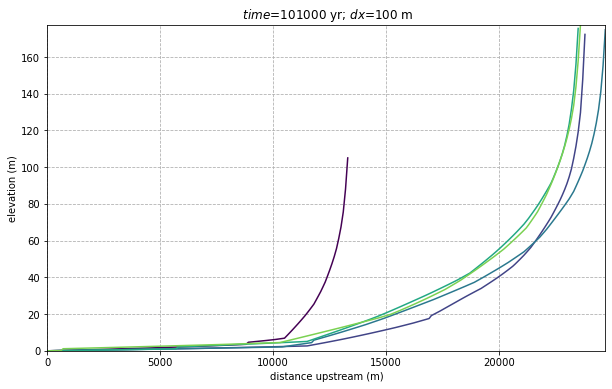

In [26]:
flow__receiver_node = mg.at_node['flow__receiver_node']
indices = np.where(mg.status_at_node[flow__receiver_node] == 0)

#calculated the first five longest 
indices = np.where(mg.status_at_node[flow__receiver_node] == 0)
prf = ChannelProfiler(mg, number_of_watersheds =5,
                     minimum_channel_threshold = dxy**2)
prf.run_one_step()

plt.figure(figsize = (10,6))
title_text = f" $time$={total_time} yr; $dx$={dxy} m"
prf.plot_profiles(xlabel='distance upstream (m)',
                  ylabel='elevation (m)',
                  title=title_text)
plt.grid(linestyle='--')
plt.rcParams.update({'font.size':14})

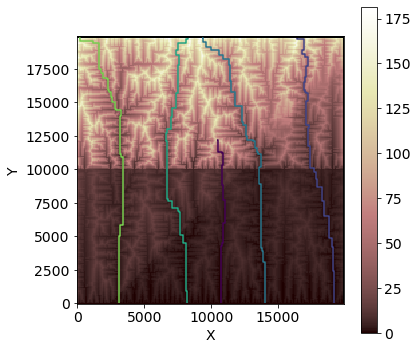

In [27]:
plt.figure(figsize = (6,6))
prf.plot_profiles_in_map_view()

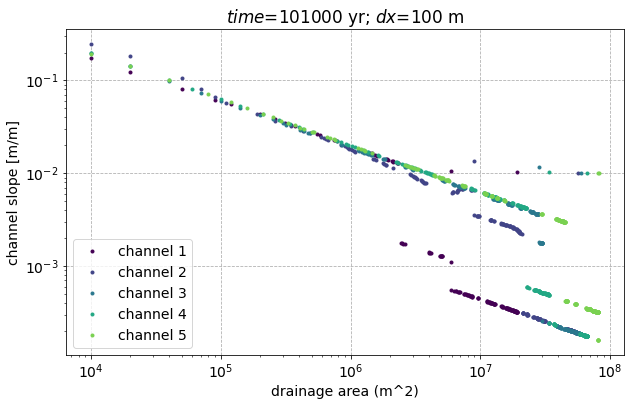

In [28]:
plt.figure(figsize = (10,6))
for i, outlet_id in enumerate(prf.data_structure):
    for j, segment_id in enumerate(prf.data_structure[outlet_id]):
        if j == 0:
            label = "channel {i}".format(i=i + 1)
        else:
            label = '_nolegend_'
        segment = prf.data_structure[outlet_id][segment_id]
        profile_ids = segment["ids"]
        color = segment["color"]
        plt.loglog(
            mg.at_node["drainage_area"][profile_ids],
            mg.at_node["topographic__steepest_slope"][profile_ids],
            '.',
            color=color,
            label=label,
        )

plt.legend(loc="lower left")
plt.xlabel("drainage area (m^2)")
plt.ylabel("channel slope [m/m]")
title_text = f"$time$={total_time} yr; $dx$={dxy} m"
plt.title(title_text)
plt.grid(linestyle='--')

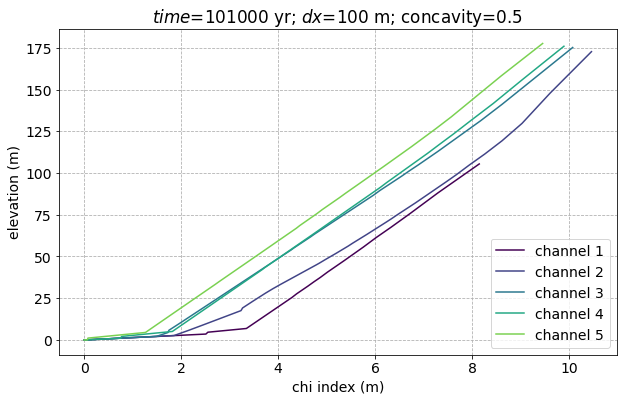

In [29]:
cf.calculate_chi()

# chi-elevation plots in the profiled channels
plt.figure(figsize = (10,6))

for i, outlet_id in enumerate(prf.data_structure):
    for j, segment_id in enumerate(prf.data_structure[outlet_id]):
        if j == 0:
            label = "channel {i}".format(i=i + 1)
        else:
            label = '_nolegend_'
        segment = prf.data_structure[outlet_id][segment_id]
        profile_ids = segment["ids"]
        color = segment["color"]
        plt.plot(
            mg.at_node["channel__chi_index"][profile_ids],
            mg.at_node["topographic__elevation"][profile_ids],
            color=color,
            label=label,
        )

plt.xlabel("chi index (m)")
plt.ylabel("elevation (m)")
plt.legend(loc="lower right")
title_text = f"$time$={total_time} yr; $dx$={dxy} m; concavity={m_sp/n_sp}"
plt.title(title_text)
plt.grid(linestyle='--')

## 4. Terrain analysis with Landlab

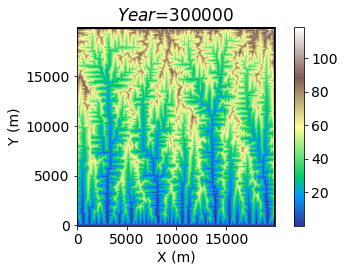

In [30]:
mg = RasterModelGrid((number_of_rows, number_of_columns), dxy)

# Create random noise
np.random.seed(0)                                       # seed set to zero so our figures are reproducible
mg_noise = np.random.rand(mg.number_of_nodes)/1000.     # intial noise on elevation grid

# set up the elevation on the grid
zr = mg.add_zeros('node', 'topographic__elevation')
zr += mg_noise
mg.set_status_at_node_on_edges(right=East, top=North, left=West, bottom=South)

U = 1E-3
uplift_rate = np.ones(mg.number_of_nodes)*U

dt = 1000            # time step [yr]
tmax = 3E5        # time for the model loop to run [yr]
total_time = 0 
t = np.arange(0, tmax, dt)

min_drainage_area = 1000
K_hs = 1E-3
K_sp = 1E-4
m_sp = 0.5                  # exponent on drainage area in stream power equation 
n_sp = 1                    # exponent on slope in stream power equation

frr = FlowAccumulator(mg) 
spr = StreamPowerEroder(mg, K_sp=K_sp, m_sp=m_sp, n_sp=n_sp, threshold_sp=0.0)
dfn = LinearDiffuser(mg, linear_diffusivity=K_hs, deposit = False)

for ti in t:
    zr[mg.core_nodes] += uplift_rate[mg.core_nodes]*dt  # uplift the landscape
    dfn.run_one_step(dt)                                # diffuse the landscape
    frr.run_one_step()                                  # route flow
    spr.run_one_step(dt)                                # fluvial incision
    total_time += dt                                    # update time keeper

imshow_grid(mg, 'topographic__elevation', grid_units=('m', 'm'), cmap='terrain', allow_colorbar=True)
title_text = '$Year$='+str(total_time)  
plt.title(title_text)
plt.tight_layout()
plt.show()

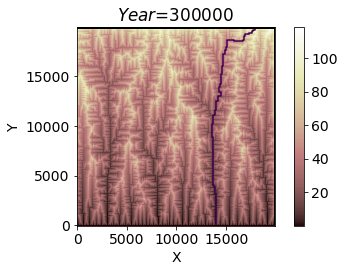

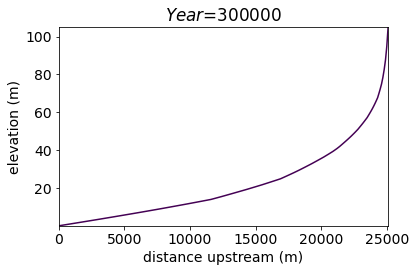

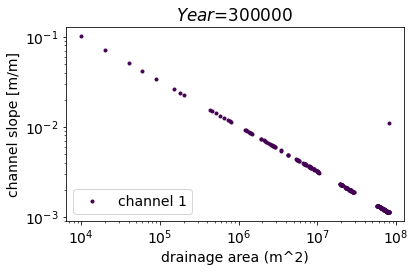

In [31]:
prf = ChannelProfiler(mg, number_of_watersheds=1, main_channel_only=True, minimum_channel_threshold=min_drainage_area)
prf.run_one_step()

plt.figure(1)
prf.plot_profiles_in_map_view()
plt.title(title_text)
plt.tight_layout()
plt.show()

plt.figure(2)
prf.plot_profiles(xlabel='distance upstream (m)', ylabel='elevation (m)')
title_text = '$Year$='+str(total_time)  
plt.title(title_text)
plt.tight_layout()
plt.show()

plt.figure(3)
for i, outlet_id in enumerate(prf.data_structure):
    for j, segment_id in enumerate(prf.data_structure[outlet_id]):
        if j == 0:
            label = "channel {i}".format(i=i + 1)
        else:
            label = '_nolegend_'
        segment = prf.data_structure[outlet_id][segment_id]
        profile_ids = segment["ids"]
        color = segment["color"]
        plt.loglog(mg.at_node["drainage_area"][profile_ids], mg.at_node["topographic__steepest_slope"][profile_ids], '.', color=color, label=label)
plt.legend(loc="lower left")
plt.xlabel("drainage area (m^2)")
plt.ylabel("channel slope [m/m]")
title_text = '$Year$='+str(total_time)  
plt.title(title_text)
plt.tight_layout()
plt.show()

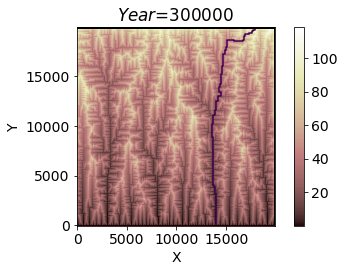

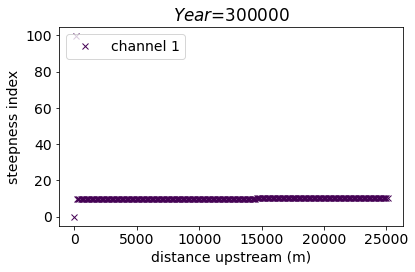

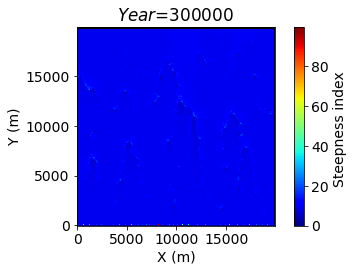

In [32]:
sf = SteepnessFinder(mg, reference_concavity=m_sp/n_sp, min_drainage_area=min_drainage_area)
sf.calculate_steepnesses()

plt.figure(1)
prf.plot_profiles_in_map_view()
plt.title(title_text)
plt.tight_layout()
plt.show()

plt.figure(2)
for i, outlet_id in enumerate(prf.data_structure):
    for j, segment_id in enumerate(prf.data_structure[outlet_id]):
        if j == 0:
            label = "channel {i}".format(i=i + 1)
        else:
            label = '_nolegend_'
        segment = prf.data_structure[outlet_id][segment_id]
        profile_ids = segment["ids"]
        distance_upstream = segment["distances"]
        color = segment["color"]
        plt.plot(distance_upstream, mg.at_node["channel__steepness_index"][profile_ids], 'x', color=color, label=label)
plt.xlabel("distance upstream (m)")
plt.ylabel("steepness index")
plt.legend(loc="upper left")
title_text = '$Year$='+str(total_time)  
plt.title(title_text)
plt.tight_layout()
plt.show()

plt.figure(3)
imshow_grid(mg, "channel__steepness_index", grid_units=("m", "m"), var_name="Steepness index ", cmap="jet")
title_text = '$Year$='+str(total_time)  
plt.title(title_text)
plt.tight_layout()
plt.show()


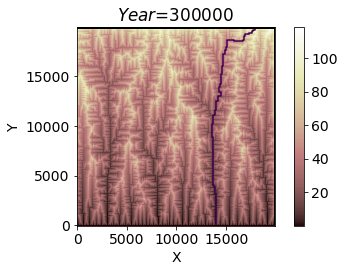

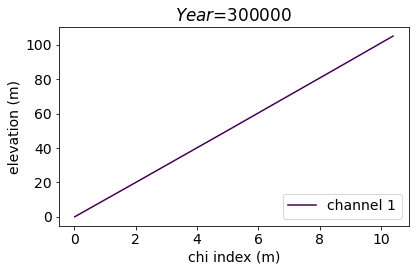

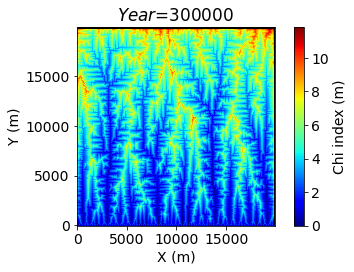

In [33]:
cf = ChiFinder(mg, reference_concavity=m_sp/n_sp, min_drainage_area=min_drainage_area)
cf.calculate_chi()

plt.figure(1)
prf.plot_profiles_in_map_view()
plt.title(title_text)
plt.tight_layout()
plt.show()

plt.figure(2)
for i, outlet_id in enumerate(prf.data_structure):
    for j, segment_id in enumerate(prf.data_structure[outlet_id]):
        if j == 0:
            label = "channel {i}".format(i=i + 1)
        else:
            label = '_nolegend_'
        segment = prf.data_structure[outlet_id][segment_id]
        profile_ids = segment["ids"]
        color = segment["color"]
        plt.plot(mg.at_node["channel__chi_index"][profile_ids], mg.at_node["topographic__elevation"][profile_ids], color=color, label=label)
plt.xlabel("chi index (m)")
plt.ylabel("elevation (m)")
plt.legend(loc="lower right")
title_text = '$Year$='+str(total_time)  
plt.title(title_text)
plt.tight_layout()
plt.show()

plt.figure(3)
imshow_grid(mg, "channel__chi_index", grid_units=("m", "m"), var_name="Chi index (m)", cmap="jet")
title_text = '$Year$='+str(total_time)  
plt.title(title_text)
plt.tight_layout()
plt.show()

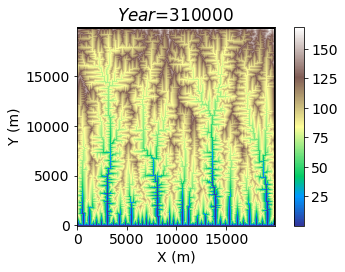

In [34]:
zr[mg.core_nodes] += 50
dt = 1000            
tmax = 1E4  
t = np.arange(0, tmax, dt)
for ti in t:
    zr[mg.core_nodes] += uplift_rate[mg.core_nodes]*dt  
    dfn.run_one_step(dt)                                
    frr.run_one_step()                                  
    spr.run_one_step(dt)                                
    total_time += dt                                    
plt.figure(1)
imshow_grid(mg, 'topographic__elevation', grid_units=('m', 'm'), cmap='terrain', allow_colorbar=True)
title_text = '$Year$='+str(total_time)  
plt.title(title_text)
plt.tight_layout()
plt.show()

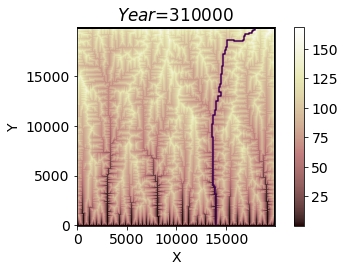

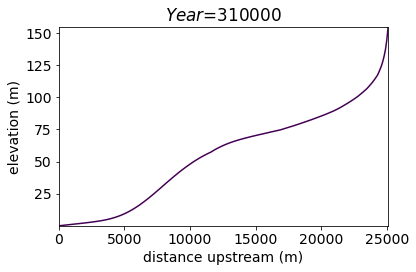

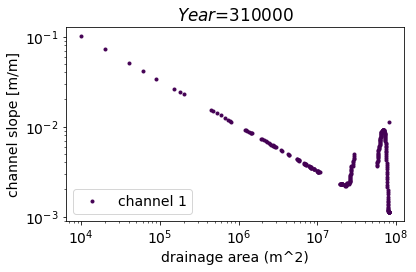

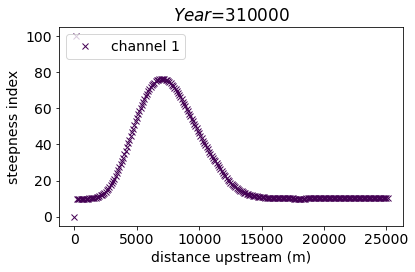

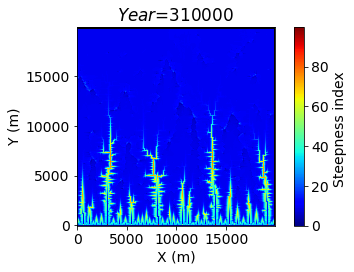

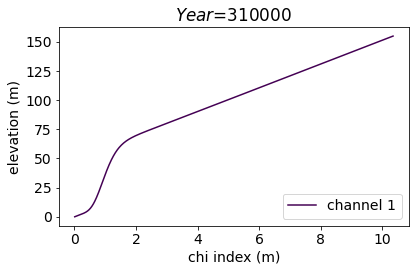

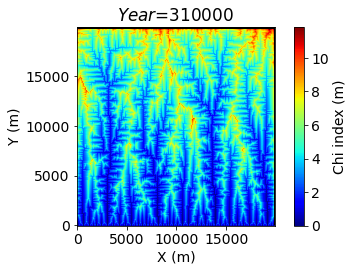

In [35]:
prf.run_one_step()

plt.figure(1)
prf.plot_profiles_in_map_view()
plt.title(title_text)
plt.tight_layout()
plt.show()

plt.figure(2)
prf.plot_profiles(xlabel='distance upstream (m)', ylabel='elevation (m)')
title_text = '$Year$='+str(total_time)  
plt.title(title_text)
plt.tight_layout()
plt.show()

plt.figure(3)
for i, outlet_id in enumerate(prf.data_structure):
    for j, segment_id in enumerate(prf.data_structure[outlet_id]):
        if j == 0:
            label = "channel {i}".format(i=i + 1)
        else:
            label = '_nolegend_'
        segment = prf.data_structure[outlet_id][segment_id]
        profile_ids = segment["ids"]
        color = segment["color"]
        plt.loglog(mg.at_node["drainage_area"][profile_ids], mg.at_node["topographic__steepest_slope"][profile_ids], '.', color=color, label=label)
plt.legend(loc="lower left")
plt.xlabel("drainage area (m^2)")
plt.ylabel("channel slope [m/m]")
title_text = '$Year$='+str(total_time)  
plt.title(title_text)
plt.tight_layout()
plt.show()

sf.calculate_steepnesses()

plt.figure(4)
for i, outlet_id in enumerate(prf.data_structure):
    for j, segment_id in enumerate(prf.data_structure[outlet_id]):
        if j == 0:
            label = "channel {i}".format(i=i + 1)
        else:
            label = '_nolegend_'
        segment = prf.data_structure[outlet_id][segment_id]
        profile_ids = segment["ids"]
        distance_upstream = segment["distances"]
        color = segment["color"]
        plt.plot(distance_upstream, mg.at_node["channel__steepness_index"][profile_ids], 'x', color=color, label=label)
plt.xlabel("distance upstream (m)")
plt.ylabel("steepness index")
plt.legend(loc="upper left")
title_text = '$Year$='+str(total_time)  
plt.title(title_text)
plt.tight_layout()
plt.show()

plt.figure(5)
imshow_grid(mg, "channel__steepness_index", grid_units=("m", "m"), var_name="Steepness index ", cmap="jet")
title_text = '$Year$='+str(total_time)  
plt.title(title_text)
plt.tight_layout()
plt.show()

cf.calculate_chi()

plt.figure(6)
for i, outlet_id in enumerate(prf.data_structure):
    for j, segment_id in enumerate(prf.data_structure[outlet_id]):
        if j == 0:
            label = "channel {i}".format(i=i + 1)
        else:
            label = '_nolegend_'
        segment = prf.data_structure[outlet_id][segment_id]
        profile_ids = segment["ids"]
        color = segment["color"]
        plt.plot(mg.at_node["channel__chi_index"][profile_ids], mg.at_node["topographic__elevation"][profile_ids], color=color, label=label)
plt.xlabel("chi index (m)")
plt.ylabel("elevation (m)")
plt.legend(loc="lower right")
title_text = '$Year$='+str(total_time)  
plt.title(title_text)
plt.tight_layout()
plt.show()

plt.figure(7)
imshow_grid(mg, "channel__chi_index", grid_units=("m", "m"), var_name="Chi index (m)", cmap="jet")
title_text = '$Year$='+str(total_time)  
plt.title(title_text)
plt.tight_layout()
plt.show()

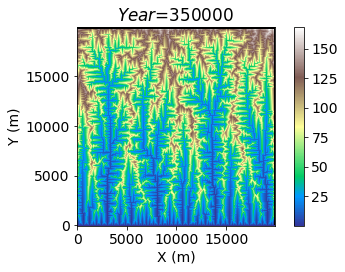

In [36]:
dt = 1000            
tmax = 4E4  
t = np.arange(0, tmax, dt)
for ti in t:
    zr[mg.core_nodes] += uplift_rate[mg.core_nodes]*dt  
    dfn.run_one_step(dt)                                
    frr.run_one_step()                                  
    spr.run_one_step(dt)                                
    total_time += dt                                    
plt.figure(1)
imshow_grid(mg, 'topographic__elevation', grid_units=('m', 'm'), cmap='terrain', allow_colorbar=True)
title_text = '$Year$='+str(total_time)  
plt.title(title_text)
plt.tight_layout()
plt.show()

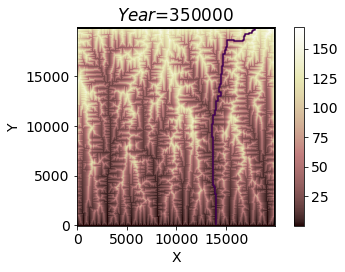

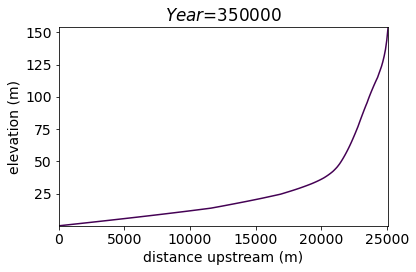

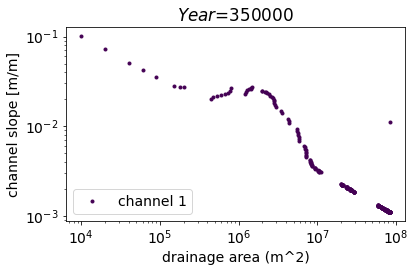

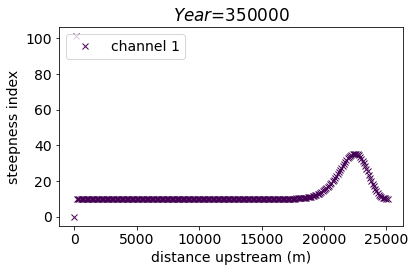

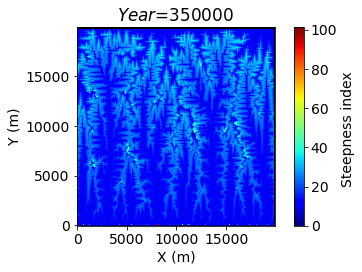

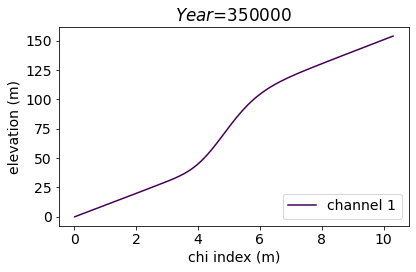

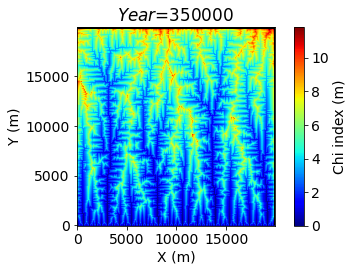

In [37]:
prf.run_one_step()

plt.figure(1)
prf.plot_profiles_in_map_view()
plt.title(title_text)
plt.tight_layout()
plt.show()

plt.figure(2)
prf.plot_profiles(xlabel='distance upstream (m)', ylabel='elevation (m)')
title_text = '$Year$='+str(total_time)  
plt.title(title_text)
plt.tight_layout()
plt.show()

plt.figure(3)
for i, outlet_id in enumerate(prf.data_structure):
    for j, segment_id in enumerate(prf.data_structure[outlet_id]):
        if j == 0:
            label = "channel {i}".format(i=i + 1)
        else:
            label = '_nolegend_'
        segment = prf.data_structure[outlet_id][segment_id]
        profile_ids = segment["ids"]
        color = segment["color"]
        plt.loglog(mg.at_node["drainage_area"][profile_ids], mg.at_node["topographic__steepest_slope"][profile_ids], '.', color=color, label=label)
plt.legend(loc="lower left")
plt.xlabel("drainage area (m^2)")
plt.ylabel("channel slope [m/m]")
title_text = '$Year$='+str(total_time)  
plt.title(title_text)
plt.tight_layout()
plt.show()

sf.calculate_steepnesses()

plt.figure(4)
for i, outlet_id in enumerate(prf.data_structure):
    for j, segment_id in enumerate(prf.data_structure[outlet_id]):
        if j == 0:
            label = "channel {i}".format(i=i + 1)
        else:
            label = '_nolegend_'
        segment = prf.data_structure[outlet_id][segment_id]
        profile_ids = segment["ids"]
        distance_upstream = segment["distances"]
        color = segment["color"]
        plt.plot(distance_upstream, mg.at_node["channel__steepness_index"][profile_ids], 'x', color=color, label=label)
plt.xlabel("distance upstream (m)")
plt.ylabel("steepness index")
plt.legend(loc="upper left")
title_text = '$Year$='+str(total_time)  
plt.title(title_text)
plt.tight_layout()
plt.show()

plt.figure(5)
imshow_grid(mg, "channel__steepness_index", grid_units=("m", "m"), var_name="Steepness index ", cmap="jet")
title_text = '$Year$='+str(total_time)  
plt.title(title_text)
plt.tight_layout()
plt.show()

cf.calculate_chi()

plt.figure(6)
for i, outlet_id in enumerate(prf.data_structure):
    for j, segment_id in enumerate(prf.data_structure[outlet_id]):
        if j == 0:
            label = "channel {i}".format(i=i + 1)
        else:
            label = '_nolegend_'
        segment = prf.data_structure[outlet_id][segment_id]
        profile_ids = segment["ids"]
        color = segment["color"]
        plt.plot(mg.at_node["channel__chi_index"][profile_ids], mg.at_node["topographic__elevation"][profile_ids], color=color, label=label)
plt.xlabel("chi index (m)")
plt.ylabel("elevation (m)")
plt.legend(loc="lower right")
title_text = '$Year$='+str(total_time)  
plt.title(title_text)
plt.tight_layout()
plt.show()

plt.figure(7)
imshow_grid(mg, "channel__chi_index", grid_units=("m", "m"), var_name="Chi index (m)", cmap="jet")
title_text = '$Year$='+str(total_time)  
plt.title(title_text)
plt.tight_layout()
plt.show()

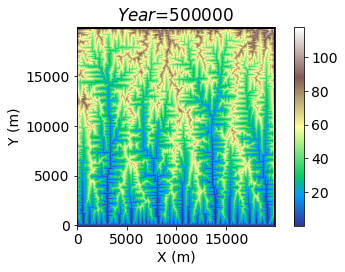

In [38]:
dt = 1000            
tmax = 1.5E5  
t = np.arange(0, tmax, dt)
for ti in t:
    zr[mg.core_nodes] += uplift_rate[mg.core_nodes]*dt  
    dfn.run_one_step(dt)                                
    frr.run_one_step()                                  
    spr.run_one_step(dt)                                
    total_time += dt                                    
plt.figure(1)
imshow_grid(mg, 'topographic__elevation', grid_units=('m', 'm'), cmap='terrain', allow_colorbar=True)
title_text = '$Year$='+str(total_time)  
plt.title(title_text)
plt.tight_layout()
plt.show()